In [7]:
import keras
from keras import layers, ops, models, utils
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [8]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

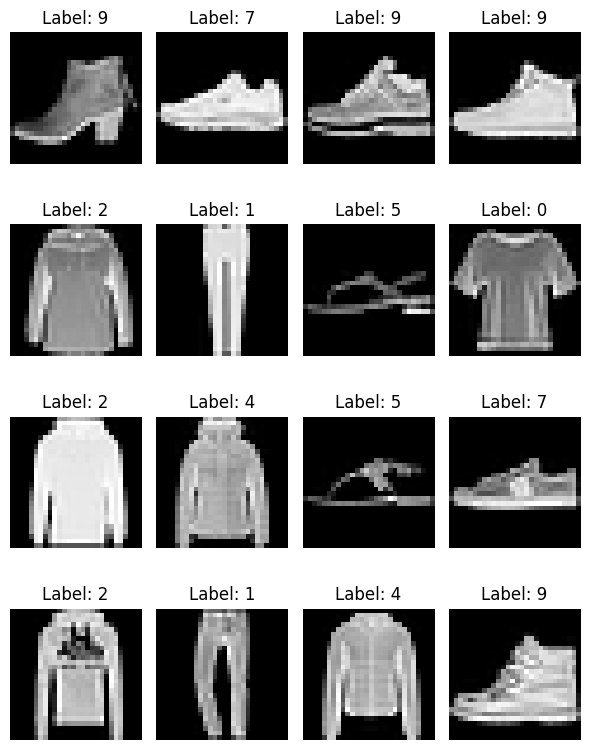

In [9]:
# Plot random sample images from X_train
num_rows = 4
num_cols = 4
num_samples = num_rows * num_cols
random_indices = np.random.choice(X_train.shape[0], num_samples, replace=False)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5*num_cols, 2*num_rows))
for i, idx in enumerate(random_indices):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title('Label: {}'.format(np.argmax(y_train[idx])))
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((54000, 28, 28),
 (54000, 10),
 (10000, 28, 28),
 (10000, 10),
 (6000, 28, 28),
 (6000, 10))

In [11]:
def build_model(hp : kt.HyperParameters):
    model = keras.Sequential()
    model.add(layers.Flatten())
    
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(
            layers.Dense(
                units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Dense(10, activation='softmax'))
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
build_model(kt.HyperParameters())

<Sequential name=sequential_1, built=False>

In [14]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=50,
    distribution_strategy=tf.distribute.OneDeviceStrategy('/device:GPU:0'),
    directory='bayesian_opt',
    overwrite=True,
    project_name='fashion_mnist'
)

In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [16]:
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Trial 50 Complete [00h 00m 29s]
val_accuracy: 0.8573333621025085

Best val_accuracy So Far: 0.8920000195503235
Total elapsed time: 00h 30m 29s


In [17]:
models = tuner.get_best_models(num_models=4)
for model in models:
    model.summary()

/home/xinchengo/miniconda3/envs/seminar/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/xinchengo/miniconda3/envs/seminar/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/xinchengo/miniconda3/envs/seminar/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (32, 784)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 384)              │       301,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 384)              │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 480)              │       184,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 480)              │       230,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 480)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 10)               │         4,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 869,770 (3.32 MB)

 Trainable params: 869,770 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (32, 784)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 160)              │       125,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 96)               │        15,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 10)               │           970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,026 (554.79 KB)

 Trainable params: 142,026 (554.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (32, 784)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 448)              │       351,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │         4,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,170 (1.36 MB)

 Trainable params: 356,170 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (32, 784)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 480)              │       376,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 384)              │       184,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 10)               │         3,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 565,354 (2.16 MB)

 Trainable params: 565,354 (2.16 MB)

 Non-trainable params: 0 (0.00 B)